In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from time import time
import matplotlib.pyplot as plt

from numba import njit
import tensorflow as tf

import sys
sys.path.append('../../../')
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel
import scipy.io as sio

In [44]:
parts = 'ACC024'
data_slope = sio.loadmat('Data/'+parts+'/CPPslopes2.mat')
data_beh = sio.loadmat('Data/'+parts+'/'+parts+'forDMA.mat')

In [45]:
print(data_slope.keys())

dict_keys(['__header__', '__version__', '__globals__', 'highSlopesM', 'highSlopesP', 'lowSlopesM', 'lowSlopesP', 'memTrials', 'percTrials', 'trialSlopes', 'datMat', 'modResults', 'TerM', 'TerP', 'driftRatesM', 'driftRatesP', 'thresholdsM', 'thresholdsP', '__function_workspace__'])


### Model 7

In [46]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # mu_drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # tau ~ U(0.1, 1.0)
    # sigma ~ ~ U(.5, 4) # is 1/lambda
    # Eta ~ U(0.0, 1.0)
    n_parameters = 6
    p_samples = np.random.uniform(low=(0.01,  0.5, 0.1, 0.1, 0.0, 0.00),
                                  high=(3.0, 2.0,  0.9, 1.0, 2.0,  2.0), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(mu_drift, boundary, beta, tau, sigma, eta, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # trial-to-trial drift rate variability
    drift_trial = mu_drift + eta * np.random.normal()
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift_trial*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # CPP slope
    cpp = np.random.normal(drift_trial, sigma)

    
    if evidence >= boundary:
        choicert =  tau + rt
        
    else:
        choicert = -tau - rt
    return choicert, cpp

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    mu_drift, boundary, beta, tau, sigma, eta = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(mu_drift, boundary, beta, tau, sigma, eta)
    return choicert, z

def batch_simulator(prior_samples, n_obs):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 6})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/CPP_single_trial_sigma_eta"
)

Networks loaded from ../../checkpoint/CPP_single_trial_sigma_eta/ckpt-500


In [47]:
# Response time and CPP
response_time = (2*data_beh['datOut'][:,1]-1)*(data_beh['datOut'][:,2])
CPP = data_slope['trialSlopes'][:,0]

# Memroy and Perceptual indecies 
mem = data_beh['datOut'][:,0]==2
perc = data_beh['datOut'][:,0]==1

data_mem_rt_cpp = np.array([response_time[mem], CPP[mem]]).T
data_perc_rt_cpp = np.array([response_time[perc], CPP[perc]]).T

In [48]:
# Validate (quick and dirty) by a specific real data
n_param_sets = 1000
n_samples = 1000

model7_param_samples_mem_rt_cpp = amortizer.sample(data_mem_rt_cpp.reshape(1,data_mem_rt_cpp.shape[0],2), n_samples=n_samples)
model7_param_samples_perc_rt_cpp = amortizer.sample(data_perc_rt_cpp.reshape(1,data_perc_rt_cpp.shape[0],2), n_samples=n_samples)

In [49]:
print(['mu_drift', 'boundary', 'beta', 'tau', 'sigma', 'eta']),
model7_param_samples_mem_rt_cpp.mean(axis=0)

['mu_drift', 'boundary', 'beta', 'tau', 'sigma', 'eta']


array([0.07110305, 1.4999669 , 0.5857079 , 0.4730065 , 0.17658205,
       0.05927143], dtype=float32)

In [50]:
print(['mu_drift', 'boundary', 'beta', 'tau', 'sigma', 'eta']),
model7_param_samples_perc_rt_cpp.mean(axis=0)

['mu_drift', 'boundary', 'beta', 'tau', 'sigma', 'eta']


array([ 0.1834504 ,  1.985086  ,  0.5142209 ,  0.7368251 ,  0.17267735,
       -0.0430799 ], dtype=float32)

In [52]:
ratio_perc = (model7_param_samples_perc_rt_cpp[:,4]**2*model7_param_samples_perc_rt_cpp[:,5]**2)/(model7_param_samples_perc_rt_cpp[:,4]**2*model7_param_samples_perc_rt_cpp[:, 5]**2 + model7_param_samples_perc_rt_cpp[:, 3]**2)
ratio_mem = (model7_param_samples_mem_rt_cpp[:,4]**2*model7_param_samples_mem_rt_cpp[:,5]**2)/(model7_param_samples_mem_rt_cpp[:,4]**2*model7_param_samples_mem_rt_cpp[:, 5]**2 + model7_param_samples_mem_rt_cpp[:, 3]**2)

In [57]:
ratio_perc.std(), ratio_mem.std()

(0.00027934316, 0.0014823121)

In [37]:
model7_x_predict_mem = batch_simulator(model7_param_samples_mem_rt_cpp, 2000).astype(np.float32)
model7_x_predict_perc = batch_simulator(model7_param_samples_perc_rt_cpp, 2000).astype(np.float32)

### Model 8

In [38]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # mu_drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # tau ~ U(0.1, 1.0)
    # sigma ~ ~ U(.5, 4) # is 1/lambda
    # gamma ~ U(0.3, 4)
    # Eta ~ U(0.0, 1.0)
    n_parameters = 6
    p_samples = np.random.uniform(low=(0.0,  0.2, 0.1, 0.0, -3, 0.0),
                                  high=(3.0, 2.0, 1.0, 2.0, 3,  2.0), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(mu_drift, boundary, tau, sigma, gamma, eta, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * 0.5
    
    # trial-to-trial drift rate variability
    drift_trial = mu_drift + eta * np.random.normal()
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift_trial*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # CPP slope
    cpp = np.random.normal(gamma*drift_trial, sigma)

    
    if evidence >= boundary:
        choicert =  tau + rt
        
    else:
        choicert = -tau - rt
    return choicert, cpp

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    mu_drift, boundary, tau, sigma, gamma, eta = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(mu_drift, boundary, tau, sigma, gamma, eta)
    return choicert, z

def batch_simulator(prior_samples, n_obs):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 6})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/CPP_single_trial_sigma_gamma_eta_wider_fixed_bias"
)

Networks loaded from ../../checkpoint/CPP_single_trial_sigma_gamma_eta_wider_fixed_bias/ckpt-500


In [39]:
# Validate (quick and dirty) by a specific real data
n_param_sets = 1000
n_samples = 1000

model8_param_samples_mem_rt_cpp = amortizer.sample(data_mem_rt_cpp.reshape(1,data_mem_rt_cpp.shape[0],2), n_samples=n_samples)
model8_param_samples_perc_rt_cpp = amortizer.sample(data_perc_rt_cpp.reshape(1,data_perc_rt_cpp.shape[0],2), n_samples=n_samples)

In [40]:
print(['mu_drift', 'boundary', 'tau', 'sigma', 'gamma', 'eta']),
model8_param_samples_perc_rt_cpp.mean(axis=0)

['mu_drift', 'boundary', 'tau', 'sigma', 'gamma', 'eta']


array([ 0.7131381 ,  2.0264142 ,  0.7301895 ,  0.06729566,  0.01220892,
       -0.02120082], dtype=float32)

In [41]:
print(['mu_drift', 'boundary', 'tau', 'sigma', 'gamma', 'eta']),
model8_param_samples_mem_rt_cpp.mean(axis=0)

['mu_drift', 'boundary', 'tau', 'sigma', 'gamma', 'eta']


array([ 0.98719674,  1.6942669 ,  0.4497564 ,  0.08510511, -0.01165222,
        0.94248897], dtype=float32)

In [42]:
model8_x_predict_mem = batch_simulator(model8_param_samples_mem_rt_cpp, 2000).astype(np.float32)
model8_x_predict_perc = batch_simulator(model8_param_samples_perc_rt_cpp, 2000).astype(np.float32)

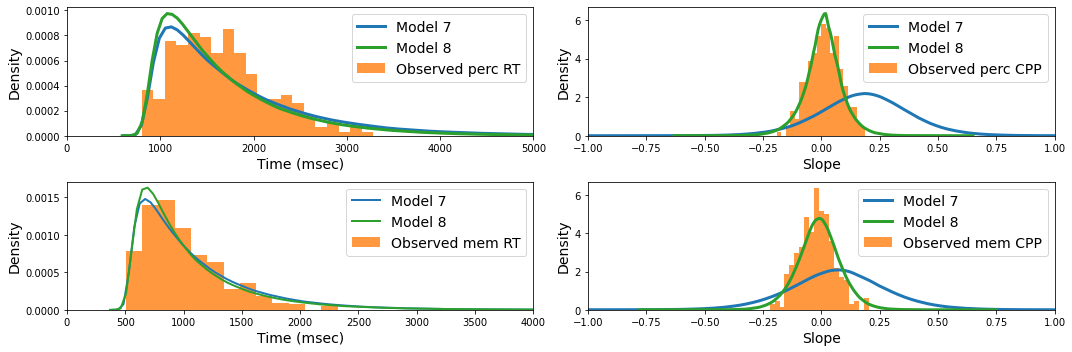

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15,5), tight_layout=True)

sns.kdeplot(1000*np.abs(model7_x_predict_perc[:,:,0]).flatten(), ax = axes[0,0], linewidth = 3, color='#1f77b4')
sns.kdeplot(1000*np.abs(model8_x_predict_perc[:,:,0]).flatten(), ax = axes[0,0], linewidth = 3, color='#2ca02c')
axes[0,0].hist(1000*np.abs(data_perc_rt_cpp[:,0]), density=True, bins = 20, color='#ff7f0e', alpha=0.8)
axes[0,0].legend(['Model 7','Model 8','Observed perc RT'], fontsize=14)
axes[0,0].set_xlabel('Time (msec)', fontsize=14)
axes[0,0].set_ylabel('Density', fontsize=14)
axes[0,0].set_xlim([0,5000])

sns.kdeplot(model7_x_predict_perc[:,:,1].flatten(), ax = axes[0,1], linewidth = 3, color='#1f77b4')
sns.kdeplot(model8_x_predict_perc[:,:,1].flatten(), ax = axes[0,1], linewidth = 3, color='#2ca02c')
axes[0,1].hist(data_perc_rt_cpp[:,1], density=True, bins = 20, color='#ff7f0e', alpha=0.8)
axes[0,1].legend(['Model 7','Model 8','Observed perc CPP'], fontsize=14)
axes[0,1].set_xlabel('Slope', fontsize=14)
axes[0,1].set_ylabel('Density', fontsize=14)
axes[0,1].set_xlim([-1,1])

sns.kdeplot(1000*np.abs(model7_x_predict_mem[:,:,0]).flatten(), ax = axes[1,0], linewidth = 2, color='#1f77b4')
sns.kdeplot(1000*np.abs(model8_x_predict_mem[:,:,0]).flatten(), ax = axes[1,0], linewidth = 2, color='#2ca02c')
axes[1,0].hist(1000*np.abs(data_mem_rt_cpp[:,0]), density=True, bins = 20, color='#ff7f0e', alpha=0.8)
axes[1,0].legend(['Model 7','Model 8','Observed mem RT'], fontsize=14)
axes[1,0].set_xlabel('Time (msec)', fontsize=14)
axes[1,0].set_ylabel('Density', fontsize=14)
axes[1,0].set_xlim([0,4000])

sns.kdeplot(model7_x_predict_mem[:,:,1].flatten(), ax = axes[1,1], linewidth = 3, color='#1f77b4')
sns.kdeplot(model8_x_predict_mem[:,:,1].flatten(), ax = axes[1,1], linewidth = 3, color='#2ca02c')
axes[1,1].hist(data_mem_rt_cpp[:,1], density=True, bins = 20, color='#ff7f0e', alpha=0.8)
axes[1,1].legend(['Model 7','Model 8','Observed mem CPP'], fontsize=14)
axes[1,1].set_xlabel('Slope', fontsize=14)
axes[1,1].set_ylabel('Density', fontsize=14)
axes[1,1].set_xlim([-1,1])

plt.savefig('Figures/CPP_data_'+parts+'.png')